https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction

Importo librerie

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import missingno as msno
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

pd.set_option('display.float', '{:.4f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

Leggo il dataset

In [20]:
#dataset = pd.read_csv("C:/Users/edoardo.frapiccini/Desktop/vai/AI/pratica/Machine learning for credit scoring/progetti/Lending Club Loan Defaulters Prediction/dataset/Lending Club 2007-2020Q3/Loan_status_2007-2020Q3.gzip")
dataset = pd.read_csv("C:\\Users\\TirocinioMatteo\\Desktop\\Python_2\\0_DATASET_LENDING\\accepted_2007_to_2018Q4.csv")

# Filtro i record che hanno solo 'Fully Paid' o 'Charged Off' come valori nella colonna 'loan_status'
dataset_with_only_fullypaid_chargedoff = dataset[(dataset['loan_status'] == 'Fully Paid') | (dataset['loan_status'] == 'Charged Off')]

#vedo feature per feature quante righe hanno valori nulli
#msno.bar(dataset_with_only_fullypaid_chargedoff)


C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\439147015.py:2: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("C:\\Users\\TirocinioMatteo\\Desktop\\Python_2\\0_DATASET_LENDING\\accepted_2007_to_2018Q4.csv")


In [21]:
# Elimino le colonne che hanno più del 50% di valori nulli
threshold = 0.5
dataset_without_feature_with_nan = dataset_with_only_fullypaid_chargedoff.dropna(thresh=threshold*len(dataset_with_only_fullypaid_chargedoff), axis=1)

#vedo feature per feature quante righe hanno valori nulli
#msno.bar(dataset_without_feature_with_nan)

In [22]:
# Elimino tutte le features che contengono la parola "last" nel nome
last_features = list(dataset_without_feature_with_nan.filter(regex='last'))
#print(last_features)
dataset_without_last_features = dataset_without_feature_with_nan[dataset_without_feature_with_nan.columns.drop(last_features)]
""" Elimino anche le seguenti features:
total_rec_int=Interest received to date
total_rec_late_fee=Late fees received to date
total_rec_prncp=Principal received to date
total_pymnt=Payments received to date for total amount funded
total_pymnt_inv=Payments received to date for portion of total amount funded by investors
perché "to date" significa "fino ad oggi", quindi indicare che queste informazioni possono essere compilate/aggiornate dopo la libera """
dataset_without_last_features.drop('total_rec_int', axis=1, inplace=True)
dataset_without_last_features.drop('total_rec_late_fee', axis=1, inplace=True)
dataset_without_last_features.drop('total_rec_prncp', axis=1, inplace=True)
dataset_without_last_features.drop('total_pymnt', axis=1, inplace=True)
dataset_without_last_features.drop('total_pymnt_inv', axis=1, inplace=True)
""" Elimino anche le seguenti features: 
funded_amnt=The total amount committed to that loan at that point in time
funded_amnt_inv=The total amount committed by investors for that loan at that point in time 
perché "at that point in time" potrebbe indicare che queste informazioni possono essere compilate/aggiornate dopo la libera """
dataset_without_last_features.drop('funded_amnt', axis=1, inplace=True)
dataset_without_last_features.drop('funded_amnt_inv', axis=1, inplace=True)
""" Elimino anche le seguenti features: 
bc_util=Ratio of total current balance to high credit/credit limit for all bankcard accounts
num_actv_rev_tl=Number of currently active revolving trades
avg_cur_bal=Average current balance of all accounts 
num_actv_bc_tl=Number of currently active bankcard accounts
num_tl_120dpd_2m=Number of accounts currently 120 days past due (updated in past 2 months)
num_tl_30dpd=Number of accounts currently 30 days past due (updated in past 2 months)
tot_cur_bal=Total current balance of all accounts
total_acc=The total number of credit lines currently in the borrower's credit file
perché "current" e "currently" potrebbero indicare che queste informazioni possono essere compilate/aggiornate dopo la libera """
dataset_without_last_features.drop('bc_util', axis=1, inplace=True)
dataset_without_last_features.drop('num_actv_rev_tl', axis=1, inplace=True)
dataset_without_last_features.drop('avg_cur_bal', axis=1, inplace=True)
dataset_without_last_features.drop('num_actv_bc_tl', axis=1, inplace=True)
dataset_without_last_features.drop('num_tl_120dpd_2m', axis=1, inplace=True)
dataset_without_last_features.drop('num_tl_30dpd', axis=1, inplace=True)
dataset_without_last_features.drop('tot_cur_bal', axis=1, inplace=True)
dataset_without_last_features.drop('total_acc', axis=1, inplace=True)

#Elimino altre features che sono troppo legate al target

#restituisce un importo solo quando è Charged Off o Default, e zero come valore in caso il prestito sia stato pagato
dataset_without_last_features.drop('recoveries', axis=1, inplace=True)
#stessa cosa per il collection_recovery_fee
dataset_without_last_features.drop('collection_recovery_fee', axis=1, inplace=True)

C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\476296242.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_without_last_features.drop('total_rec_int', axis=1, inplace=True)
C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\476296242.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_without_last_features.drop('total_rec_late_fee', axis=1, inplace=True)
C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\476296242.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

Esplorazione dei dati numerici

https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/Correlation_CoefficientsAppropriate_Use_and.50.aspx


In [23]:
# Seleziona solo le colonne numeriche
numeric_features = dataset_without_last_features.select_dtypes(include=['int', 'float'])

# Ottieni i nomi delle feature numeriche
numeric_feature_names = numeric_features.columns
#print(numeric_features.shape)
#print(numeric_feature_names)

numerical_data = dataset_without_last_features.select_dtypes(include=[np.number])

correlation_matrix = numerical_data.corr()

# Filtra la matrice di correlazione per ottenere le coppie di features con correlazione maggiore del 69%
high_correlation_pairs = correlation_matrix[abs(correlation_matrix) > 0.69].stack().reset_index()
high_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Rimuovi le coppie identiche e le correlazioni con se stesse
high_correlation_pairs = high_correlation_pairs.loc[(high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2'])]

# Stampa le coppie di features con correlazione maggiore del 69%
high_correlation_pairs.to_csv('numeric_high_correlation_pairs.csv')

In [24]:
# Trasformo loan_status in una variabile binaria
dataset_without_last_features['loan_status'] = dataset_without_last_features.loan_status.map({'Fully Paid':1, 'Charged Off':0})

# Seleziona solo le colonne numeriche inclusa loan status
numeric_features = dataset_without_last_features.select_dtypes(include=['int', 'float'])

# Trovo tutte le correlazioni tra le colonne numeriche e la variabile target
correlation_with_target = numeric_features.corrwith(numeric_features['loan_status'])

# Stampa le correlazioni con la variabile target in un excel
correlation_with_target.to_csv('correlation_with_target.csv')

C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\682281808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_without_last_features['loan_status'] = dataset_without_last_features.loan_status.map({'Fully Paid':1, 'Charged Off':0})
c:\Users\TirocinioMatteo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\TirocinioMatteo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Elimino le feature maggiormente correllate

In [25]:
#descrizioni features
#https://www.kaggle.com/code/braindeadcoder/understanding-lending-club-s-data-with-eda
#https://wiki.datrics.ai/more-features

dataset_without_numeric_correlation = dataset_without_last_features.copy()

#Scelgo loan_amnt perché ha una correlazione maggiore con loan_status rispetto a installment
#loan_amnt ha una correlazione con installment di 0.95
dataset_without_numeric_correlation.drop('installment', axis=1, inplace=True)

def calculate_risk_score(row):
    return (row['fico_range_low'] + row['fico_range_high']) / 2
dataset_without_numeric_correlation['risk_score'] = dataset_without_numeric_correlation.apply(calculate_risk_score, axis=1) 
dataset_without_numeric_correlation.drop(columns=['fico_range_low', 'fico_range_high'], inplace=True)

#Scelgo num_rev_tl_bal_gt_0 perché ha una correlazione maggiore con loan_status rispetto a num_op_rev_tl
#num_rev_tl_bal_gt_0 ha una correlazione con num_op_rev_tl di 0.80
dataset_without_numeric_correlation.drop('num_op_rev_tl', axis=1, inplace=True)

#Scelgo open_acc perché ha una correlazione maggiore con loan_status rispetto a num_sats
#open_acc ha una correlazione con num_sats di 1
dataset_without_numeric_correlation.drop('num_sats', axis=1, inplace=True)

#Scelgo pub_rec perché ha una correlazione maggiore con loan_status rispetto a tax_liens
#pub_rec ha una correlazione con tax_liens di 0.70
dataset_without_numeric_correlation.drop('tax_liens', axis=1, inplace=True)

#Scelgo bc_open_to_buy perché ha una correlazione maggiore con loan_status rispetto a total_bc_limit
#bc_open_to_buy ha una correlazione con total_bc_limit di 0.84
dataset_without_numeric_correlation.drop('total_bc_limit', axis=1, inplace=True)

#Scelgo total_rev_hi_lim perché ha una correlazione maggiore con loan_status rispetto a revol_bal
#total_rev_hi_lim ha una correlazione con revol_bal di 0.81
dataset_without_numeric_correlation.drop('revol_bal', axis=1, inplace=True)

#Scelgo percent_bc_gt_75 perché ha una correlazione maggiore con loan_status rispetto a revol_util
#percent_bc_gt_75 ha una correlazione con revol_util di 0.73
dataset_without_numeric_correlation.drop('revol_util', axis=1, inplace=True)

#Scelgo acc_open_past_24mths perché ha una correlazione maggiore con loan_status rispetto a num_tl_op_past_12m
#acc_open_past_24mths ha una correlazione con num_tl_op_past_12m di 0.76
dataset_without_numeric_correlation.drop('num_tl_op_past_12m', axis=1, inplace=True)

#Scelgo num_bc_tl perché ha una correlazione maggiore con loan_status rispetto a num_bc_sats e num_rev_accts
#num_bc_tl ha una correlazione con num_bc_sats di 0.72
dataset_without_numeric_correlation.drop('num_bc_sats', axis=1, inplace=True)
#num_bc_tl ha una correlazione con num_rev_accts di 0.84
dataset_without_numeric_correlation.drop('num_rev_accts', axis=1, inplace=True)

#Scelgo total_bal_ex_mort perché ha una correlazione maggiore con loan_status rispetto a total_il_high_credit_limit
#total_bal_ex_mort ha una correlazione con total_il_high_credit_limit di 0.87
dataset_without_numeric_correlation.drop('total_il_high_credit_limit', axis=1, inplace=True)


In [26]:
""" numerical_data = dataset_without_numeric_correlation.select_dtypes(include=[np.number])

correlation_matrix = numerical_data.corr()

# Filtra la matrice di correlazione per ottenere le coppie di features con correlazione maggiore del 69%
high_correlation_pairs = correlation_matrix[abs(correlation_matrix) > 0.69].stack().reset_index()
high_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Rimuovi le coppie identiche e le correlazioni con se stesse
high_correlation_pairs = high_correlation_pairs.loc[(high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2'])]

# Stampa le coppie di features con correlazione maggiore del 69%
high_correlation_pairs.to_csv('numeric_high_correlation_pairs.csv') """

" numerical_data = dataset_without_numeric_correlation.select_dtypes(include=[np.number])\n\ncorrelation_matrix = numerical_data.corr()\n\n# Filtra la matrice di correlazione per ottenere le coppie di features con correlazione maggiore del 69%\nhigh_correlation_pairs = correlation_matrix[abs(correlation_matrix) > 0.69].stack().reset_index()\nhigh_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']\n\n# Rimuovi le coppie identiche e le correlazioni con se stesse\nhigh_correlation_pairs = high_correlation_pairs.loc[(high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2'])]\n\n# Stampa le coppie di features con correlazione maggiore del 69%\nhigh_correlation_pairs.to_csv('numeric_high_correlation_pairs.csv') "

Esplorazione dei dati numerici (2)

In [27]:
""" def getFirstPlots(numeric_feature_names, n, data):
    numeric_features_plot = []
    count = 0
    for numeric_feature in numeric_feature_names:
        if numeric_feature != 'loan_status':
            if(count < n):
                plot = dataset_without_numeric_correlation.hvplot.hist(
                    y=numeric_feature, by='loan_status', subplots=False, 
                    width=300, height=350, bins=50, alpha=0.4, 
                    title=f"{numeric_feature} by Loan Status", 
                    legend='top'
                )
                numeric_features_plot.append(plot)
                #print(numeric_feature)
            count += 1
    for plot in numeric_features_plot:
        if plot == numeric_features_plot[0]:
            combined_plot = plot
        else:
            combined_plot += plot
    return combined_plot

def getCentralPlots(numeric_feature_names, n, o, data):
    numeric_features_plot = []
    count = 0
    for numeric_feature in numeric_feature_names:
        if numeric_feature != 'loan_status':
            if count >= n and count < o:
                plot = dataset_without_numeric_correlation.hvplot.hist(
                    y=numeric_feature, by='loan_status', subplots=False, 
                    width=300, height=350, bins=50, alpha=0.4, 
                    title=f"{numeric_feature} by Loan Status", 
                    legend='top'
                )
                numeric_features_plot.append(plot)
                #print(numeric_feature)
            count += 1
    for plot in numeric_features_plot:
        if plot == numeric_features_plot[0]:
            combined_plot = plot
        else:
            combined_plot += plot
    return combined_plot

def getLastPlots(numeric_feature_names, o, data):
    numeric_features_plot = []
    count = 0
    for numeric_feature in numeric_feature_names:
        if numeric_feature != 'loan_status':
            if count >= o:
                plot = dataset_without_numeric_correlation.hvplot.hist(
                    y=numeric_feature, by='loan_status', subplots=False, 
                    width=300, height=450, bins=50, alpha=0.4, 
                    title=f"{numeric_feature} by Loan Status", 
                    legend='top'
                )
                numeric_features_plot.append(plot)
                #print(numeric_feature)
            count += 1
    for plot in numeric_features_plot:
        if plot == numeric_features_plot[0]:
            combined_plot = plot
        else:
            combined_plot += plot
    return combined_plot """

' def getFirstPlots(numeric_feature_names, n, data):\n    numeric_features_plot = []\n    count = 0\n    for numeric_feature in numeric_feature_names:\n        if numeric_feature != \'loan_status\':\n            if(count < n):\n                plot = dataset_without_numeric_correlation.hvplot.hist(\n                    y=numeric_feature, by=\'loan_status\', subplots=False, \n                    width=300, height=350, bins=50, alpha=0.4, \n                    title=f"{numeric_feature} by Loan Status", \n                    legend=\'top\'\n                )\n                numeric_features_plot.append(plot)\n                #print(numeric_feature)\n            count += 1\n    for plot in numeric_features_plot:\n        if plot == numeric_features_plot[0]:\n            combined_plot = plot\n        else:\n            combined_plot += plot\n    return combined_plot\n\ndef getCentralPlots(numeric_feature_names, n, o, data):\n    numeric_features_plot = []\n    count = 0\n    for numeric_fe

In [28]:
""" getFirstPlots(numeric_feature_names, 20, data) """

' getFirstPlots(numeric_feature_names, 20, data) '

In [29]:
""" #getCentralPlots(numeric_feature_names, 4, 8, data)
getLastPlots(numeric_feature_names, 20, data) """

' #getCentralPlots(numeric_feature_names, 4, 8, data)\ngetLastPlots(numeric_feature_names, 20, data) '

esploro variabili categoriche

In [30]:
""" # Seleziona solo le colonne non numeriche
non_numeric_features = dataset_without_numeric_correlation.select_dtypes(exclude=['int', 'float'])

# Ottieni i nomi delle feature non numeriche
non_numeric_feature_names = non_numeric_features.columns """
""" print(non_numeric_features.shape)
print(non_numeric_feature_names) """

' print(non_numeric_features.shape)\nprint(non_numeric_feature_names) '

Processo le variabili categoriche

In [31]:
data_with_categorical_variables_processed = dataset_without_numeric_correlation.copy()

#elimino la colonna id
data_with_categorical_variables_processed.drop('id', axis=1, inplace=True)
#elimino la colonna url
data_with_categorical_variables_processed.drop('url', axis=1, inplace=True)

#elimino la colonna grade, perché tengo la sua sottocategoria: sub_grade
data_with_categorical_variables_processed.drop('grade', axis=1, inplace=True)
#elimino sub_grade perché è un info che ha solo Lending Club
data_with_categorical_variables_processed.drop('sub_grade', axis=1, inplace=True)

#elimino la colonna issue_d, perché non so in anticipo se un prestito verrà emesso o meno quando si utilizza il nostro modello
data_with_categorical_variables_processed.drop('issue_d', axis=1, inplace=True)

#elimino la colonna pymnt_plan, perché questa variabile in base alla variabile dipendente ha una distribuzione costante
data_with_categorical_variables_processed.drop('pymnt_plan', axis=1, inplace=True)
#elimino la colonna hardship_flag, perché questa variabile in base alla variabile dipendente ha una distribuzione costante
data_with_categorical_variables_processed.drop('hardship_flag', axis=1, inplace=True)

#elimino la colonna title, perché posso vedere questa variabile come una sottocategoria di purpose
data_with_categorical_variables_processed.drop('title', axis=1, inplace=True)




#home_ownership: unisco le categorie ANY e NONE in OTHER
data_with_categorical_variables_processed.loc[(data_with_categorical_variables_processed.home_ownership == 'ANY') | (data_with_categorical_variables_processed.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER' 

#earliest_cr_line
##trasformo earliest_cr_line in una data
data_with_categorical_variables_processed['earliest_cr_line'] = pd.to_datetime(data_with_categorical_variables_processed['earliest_cr_line'])
##tengo solo l'anno
data_with_categorical_variables_processed['earliest_cr_line'] = data_with_categorical_variables_processed.earliest_cr_line.dt.year

#trasformo la colonna term in una variabile numerica
term_values = {' 36 months': 36, ' 60 months': 60}
data_with_categorical_variables_processed['term'] = data_with_categorical_variables_processed.term.map(term_values)
#disbursement_method
data_with_categorical_variables_processed['disbursement_method'] = data_with_categorical_variables_processed['disbursement_method'].replace({'Cash': 0, 'DirectPay': 1})
#debt_settlement_flag
data_with_categorical_variables_processed['debt_settlement_flag'] = data_with_categorical_variables_processed['debt_settlement_flag'].replace({'N': 0, 'Y': 1})
#addr_state
#converto i valori categorici in numerici
le = LabelEncoder()
data_with_categorical_variables_processed['addr_state'] = le.fit_transform(data_with_categorical_variables_processed['addr_state'])

#converto i valori booleani in numerici
bool_columns = data_with_categorical_variables_processed.select_dtypes(include='bool').columns
data_with_categorical_variables_processed[bool_columns] = data_with_categorical_variables_processed[bool_columns].astype(int)

#trasformo le colonne sub_grade, verification_status, purpose, initial_list_status, application_type, home_ownership in variabili dummy
dummies = ['verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
data_with_categorical_variables_processed = pd.get_dummies(data_with_categorical_variables_processed, columns=dummies, drop_first=True)



#elimino i record con valori mancanti
data_with_categorical_variables_processed.dropna(inplace=True)



#della colonna zip_code tengo solo i primi 3 caratteri
data_with_categorical_variables_processed['zip_code'] = data_with_categorical_variables_processed['zip_code'].str.slice(stop=3)
data_with_categorical_variables_processed['zip_code'] = data_with_categorical_variables_processed['zip_code'].astype(int)



C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\2574462693.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_with_categorical_variables_processed['earliest_cr_line'] = pd.to_datetime(data_with_categorical_variables_processed['earliest_cr_line'])
C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\2574462693.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_categorical_variables_processed['disbursement_method'] = data_with_categorical_variables_processed['disbursement_method'].replace({'Cash': 0, 'DirectPay': 1})
C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\257446269

In [32]:
def replaceProfession(data_with_professions_focus, profession):
    category = data_with_professions_focus['emp_title'].str.contains(profession, case=False)
    data_with_professions_focus.loc[category, 'emp_title'] = profession
    return data_with_professions_focus

In [33]:
# Copia del DataFrame originale
data_with_professions_focus = data_with_categorical_variables_processed.copy()

# Trasformazione delle professioni in minuscolo e rimozione spazi bianchi
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].str.lower().str.strip().str.replace(' ', '_')

#Raggruppo le professioni in categorie 
#professioni sanitarie e sociali
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'nurse')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'therapist')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'medical')
health_and_social_care = ['nurse','therapist','medical','lpn','cna','social_worker','rn','paramedic','physician','lvn','phlebotomist']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(health_and_social_care, 'health_and_social_care')

#farmacisti
pharmacist = ['pharmacist','pharmacy_technician']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(pharmacist, 'pharmacist')

#dentisti
dentist = ['dentist','dental_hygienist']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(dentist, 'dentist')

#istruzione
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'teacher')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'professor')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'school')
instruction = ['teacher','professor','school','educator','instructor']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(instruction, 'instruction')

#postini
postman = ['letter_carrier','mail_carrier','courier']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(postman, 'postman')

#presidenti
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'president')
president = ['owner','president','ceo','executive_director','principal','vp','general_manager','gm','cfo','coo']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(president, 'president')

#professioni legali e giuridiche
legal_and_juridical = ['attorney','paralegal','legal_assistant','correctional_officer']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(legal_and_juridical, 'legal_and_juridical')

#cuochi
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'chef')
catering = ['chef','server','bartender','cook']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(catering, 'catering')

#militari e sicurezza
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'officer')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'security')
security = ['officer','firefighter','deputy_sheriff','deputy','inspector','sergeant','captain','us_army','detective','investigator','lieutenant','shipping']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(security, 'security')

#autisti
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'driver')
driver = ['driver','conductor','courier','bus_operator','pilot','carrier']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(driver, 'driver')

#tecnologia e ingegneria
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'engineer')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'tech')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'program')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'developer')
engineering_and_technology = ['engineer','tech','program','it','developer','it_specialist','electrician',
                              'systems_analyst','systems_administrator','installer','service_technician']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(engineering_and_technology, 'engineering_and_technology')

#produzione e operazioni
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'operator')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'warehouse')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'technician')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'mechanic')
production_and_operations = ['operator','technician','warehouse','mechanic','maintenance','carpenter', 'machinist','laborer','production_worker',
                             'plumber','material_handler','custodian','welder','lineman']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(production_and_operations, 'production_and_operations')

#management
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'manager')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'supervisor')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'director')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'admin')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'lead')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'managing')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'management')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'coordinator')
management = ['manager','supervisor','director','admin','lead','managing','management','superintendent','management','coordinator','dispatcher',
              'foreman']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(management, 'management')

#vendite e business
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'sales')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'account')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'business')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'finance')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'financial')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'bank')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'credit')
business = ['sales','account','business','finance','financial','bank','credit','agent','controller','analyst','buyer','auditor','marketing','teller',
            'realtor','clerk','cashier','associate','underwriter','loan_officer','bookkeeper','clerical']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(business, 'business')

#assistenti
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'assistant')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'secretary')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'attendant')
assistant = ['assistant','secretary','attendant','receptionist','customer_service','customer_service_rep',
              'customer_service_representative','csr','caregiver']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(assistant, 'assistant')

#consulenti
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'consultant')
data_with_professions_focus = replaceProfession(data_with_professions_focus, 'advisor')
consultant = ['consultant','advisor','counselor']
data_with_professions_focus['emp_title'] = data_with_professions_focus['emp_title'].replace(consultant, 'consultant')

#other_frequent_professions = ['partner','pastor','recruiter','human_resources','claims_adjuster']

# Salvataggio dei risultati in un file CSV
data_with_professions_focus['emp_title'].value_counts().head(100).to_csv('professions.csv')

print(data_with_professions_focus.shape)
# stampo la distribuzione della variabile traget 
print(data_with_professions_focus['loan_status'].value_counts(normalize=True))

frequent_professions = data_with_professions_focus['emp_title'].value_counts().head(100).index
data_with_professions_focus = data_with_professions_focus[data_with_professions_focus['emp_title'].isin(frequent_professions)] 
print(data_with_professions_focus.shape)
# stampo la distribuzione della variabile traget 
print(data_with_professions_focus['loan_status'].value_counts(normalize=True))

data_with_professions_focus = pd.get_dummies(data_with_professions_focus, columns=['emp_title'], drop_first=True)
print(data_with_professions_focus.shape)

# stampo la distribuzione della variabile traget 
print(data_with_professions_focus['loan_status'].value_counts(normalize=True))


(1044005, 65)
loan_status
1   0.7968
0   0.2032
Name: proportion, dtype: float64
(756435, 65)
loan_status
1   0.7953
0   0.2047
Name: proportion, dtype: float64
(756435, 163)
loan_status
1   0.7953
0   0.2047
Name: proportion, dtype: float64


In [34]:
#analisi emp_length (durata della professione attuale)
data_with_profession_duration_focus = data_with_professions_focus.copy()
data_with_profession_duration_focus['emp_length'] = data_with_profession_duration_focus['emp_length'].replace({'10+': '11'}, regex=True)
data_with_profession_duration_focus['emp_length'] = data_with_profession_duration_focus['emp_length'].str.replace(r'\D', '', regex=True)
data_with_profession_duration_focus['emp_length'] = pd.to_numeric(data_with_profession_duration_focus['emp_length'])

In [35]:
""" #elimino le feature con varianza nulla
data = data_with_profession_duration_focus.copy()
data.drop(['out_prncp','out_prncp_inv','policy_code'], axis=1, inplace=True) """

data = data_with_profession_duration_focus.copy()
print(data.shape)
#calcolo la varianza di ogni feature
variance = data.var()
#elimino le feature con varianza nulla
data = data.loc[:, variance > 0]
print(data.shape)

(756435, 163)
(756435, 160)


Do un'occhiata alle nuove correlazioni

In [36]:
correlation_matrix = data.corr()

# Filtra la matrice di correlazione per ottenere le coppie di features con correlazione maggiore del 69%
high_correlation_pairs = correlation_matrix[abs(correlation_matrix) > 0.69].stack().reset_index()
high_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Rimuovi le coppie identiche e le correlazioni con se stesse
high_correlation_pairs = high_correlation_pairs.loc[(high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2'])]

# Stampa le coppie di features con correlazione maggiore del 69%
high_correlation_pairs.to_csv('high_correlation_pairs.csv')

In [37]:
# Seleziona solo le colonne numeriche inclusa loan status
numeric_features = data.select_dtypes(include=['int', 'float'])

# Trovo tutte le correlazioni tra le colonne numeriche e la variabile target
correlation_with_target = numeric_features.corrwith(numeric_features['loan_status'])

# Stampa le correlazioni con la variabile target in un excel
correlation_with_target.to_csv('correlation_with_target.csv')

In [38]:
#Scelgo mo_sin_old_rev_tl_op perché ha una correlazione maggiore con loan_status rispetto a earliest_cr_line
#mo_sin_old_rev_tl_op ha una correlazione con earliest_cr_line di 0.90
data.drop('earliest_cr_line', axis=1, inplace=True)



Splitto il dataset in train e test

In [39]:
train, test = train_test_split(data, test_size=0.33, random_state=42)
#printo le dimensioni per debug
print(data.shape)
print(data.shape[0]/2)
print(train.shape)
print(test.shape)

""" #rimuovo gli outliers nel dataset di training
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000] """

#bilancio il training set
""" #undersampling
#creo un dataset con tutti i casi in cui loan_status è 1 e un dataset con tutti i casi in cui loan_status è 0
train_1 = train[train['loan_status'] == 1]
train_0 = train[train['loan_status'] == 0]
#undersampling di data_1
train_1 = train_1.sample(n=train_0.shape[0], random_state=0)
#concateno i due dataset (data_0 e data_1 sottocampionato)
train = pd.concat([train_0, train_1], ignore_index=True)
#mescolo il dataset
train = train.sample(frac=1).reset_index(drop=True)
#printo i risultati
counts = train['loan_status'].value_counts()
print("Numero di valori 1:", counts[1]) 
print("Numero di valori 0:", counts[0])

X_train, y_train = train.drop('loan_status', axis=1), train.loan_status """

#oversampling con SMOTE
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(train.drop('loan_status', axis=1), train.loan_status.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
 
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

(756435, 159)
378217.5
(506811, 159)
(249624, 159)


C:\Users\TirocinioMatteo\AppData\Local\Temp\ipykernel_26088\758740357.py:36: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train, y_train = sm.fit_resample(train.drop('loan_status', axis=1), train.loan_status.ravel())


After OverSampling, counts of label '1': 403246
After OverSampling, counts of label '0': 403246


Normalizzo X_train e X_test

In [40]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 🤖 Models Building

In [41]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

## Funzione  per trovare la soglia ottimale in base alla metrica 

In [43]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import confusion_matrix as cm_sklearn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def plot_discrimination_threshold(clf, X_test, y_test, argmax, title='Metriche al variare della soglia', fig_size=(10, 8), dpi=100, save_fig_path=None):
    """
    Plot precision, recall and f1-score vs discriminant threshold for the given pipeline model
    Parameters
    ----------
    clf : estimator instance (either sklearn.Pipeline, imblearn.Pipeline or a classifier)
        PRE-FITTED classifier or a PRE-FITTED Pipeline in which the last estimator is a classifier.
    X_test : pandas.DataFrame of shape (n_samples, n_features)
        Test features.
    y_test : pandas.Series of shape (n_samples,)
        Target values.
    argmax : str, default: 'f1'
        Annotate the threshold maximized by the supplied metric. Options: 'f1', 'precision', 'recall'
    title : str, default ='FPR and FNR vs Discriminant Threshold'
        Plot title.
    fig_size : tuple, default = (10, 8)
        Size (inches) of the plot.
    dpi : int, default = 100
        Image DPI.
    save_fig_path : str, defaut=None
        Full path where to save the plot. Will generate the folders if they don't exist already.
    Returns
    -------
        fig : Matplotlib.pyplot.Figure
            Figure from matplotlib
        ax : Matplotlib.pyplot.Axe
            Axe object from matplotlib
    """
        
    #thresholds = np.linspace(0, 1, 100)
    thresholds = np.arange(0, 1.002, 0.002)

    precision_ls = []
    recall_ls = []
    f1_ls = []
    acc_ls = []
    roc_auc_ls = []

    fpr_ls = []
    fnr_ls = []
    tpr_ls = []
    tnr_ls = []
    
    # calcolo probabilità
    probs = clf.predict_proba(X_test)[:,1]

    # per rete neurale
    # probs = clf.predict(X_test).astype(float).flatten()
    # Aggiungo un pramettino... ANN=True o False 
    
    for threshold in thresholds:   
    
        # Calcolo le predizioni, se la probabilità è maggiore della soglia, allora 1, altrimenti 0
        y_predictions = np.where(probs>=threshold, 1, 0) 
        
        # Ottengo la Matrice di Confusione
        tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()
        
        # Calcolo tutti i tassi
        FPR = fp / (tn + fp)
        FNR = fn / (tp + fn)
        TPR = tp / (tp + fn)
        TNR = tn / (tn + fp)
        
        # Calcolo le metriche:
        precision = precision_score(y_test, y_predictions, average='binary')
        recall = recall_score(y_test, y_predictions, average='binary')
        f1 = f1_score(y_test, y_predictions, average='binary')
        acc= accuracy_score(y_test, y_predictions)
        roc_auc = roc_auc_score(y_test, y_predictions)
        
        # Salvo le metriche nelle liste 
        precision_ls.append(precision)
        recall_ls.append(recall)
        f1_ls.append(f1)
        acc_ls.append(acc)
        roc_auc_ls.append(roc_auc)
        
        fpr_ls.append(FPR)
        fnr_ls.append(FNR)
        tpr_ls.append(TPR)
        tnr_ls.append(TNR)
              
    metrics = pd.concat([
        pd.Series(precision_ls),
        pd.Series(recall_ls),
        pd.Series(f1_ls),
        pd.Series(acc_ls),
        pd.Series(roc_auc_ls),
        pd.Series(fpr_ls),
        pd.Series(fnr_ls),
        pd.Series(tpr_ls),
        pd.Series(tnr_ls)],
                        axis=1)
    

    metrics.columns = ['precision', 'recall', 'f1', 'acc','roc_auc', 'fpr', 'fnr', 'tpr', 'tnr']
    metrics.index = thresholds
    
    plt.rcParams["figure.facecolor"] = 'white'
    plt.rcParams["axes.facecolor"] = 'white'
    plt.rcParams["savefig.facecolor"] = 'white'
                
    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
    ax.plot(metrics['precision'], label='Precision')
    ax.plot(metrics['recall'], label='Recall')
    ax.plot(metrics['f1'], label='f1')
    ax.plot(metrics['acc'], label='Accuracy')
    ax.plot(metrics['roc_auc'], label='ROC AUC')
    ax.plot(metrics['fpr'], label='False Positive Rate (FPR)', linestyle='dotted')
    ax.plot(metrics['fnr'], label='False Negative Rate (FNR)', linestyle='dotted')
    #ax.plot(metrics['tpr'], label='True Positive Rate (TPR)', linestyle='dotted')
    #ax.plot(metrics['tnr'], label='True Negative Rate (TNR)', linestyle='dotted')
    
    
    # Disegno la linea verticale per la soglia che massimizza la metrica
    disc_threshold = round(metrics[argmax].idxmax(), 3)
    ax.axvline(x=metrics[argmax].idxmax(), color='black', linestyle='dashed', label="$t_r$="+str(disc_threshold))

    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_formatter('{x:.1f}')
    
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_formatter('{x:.1f}')

    ax.xaxis.set_minor_locator(MultipleLocator(0.05))    
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))    

    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4, color='black') 
    
    plt.grid(True)
    
    plt.xlabel('Probability Threshold', fontsize=18)
    plt.ylabel('Scores', fontsize=18)
    plt.title(title, fontsize=18)
    leg = ax.legend(loc='best', frameon=True, framealpha=0.7)
    leg_frame = leg.get_frame()
    leg_frame.set_color('gold')
    plt.show()

    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path, dpi=dpi)

    return fig, ax, disc_threshold

In [44]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

# ✔️ Artificial Neural Networks (ANNs)

In [45]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ),)
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

def getRecordsWithIncorrectPrediction(y_test_pred, y_test):
    X_test_to_detect_errors = test.drop('loan_status', axis=1)
    x_errors = X_test_to_detect_errors[y_test_pred != y_test]
    errors = pd.DataFrame(x_errors, columns=X_test_to_detect_errors.columns)
    y_errors = y_test[y_test_pred != y_test]
    errors['loan_status'] = y_errors
    print(errors)
    return errors

def getRecordsIndexWithIncorrectPrediction(y_test_pred, y_test):
    errors_index = []
    for i in range(len(y_test_pred)):
        if y_test_pred[i] != y_test[i]:
            errors_index.append(i)
    return errors_index

def compareTwoModels(index1, index2):
    # Converti gli array in set per utilizzare le operazioni di set
    set_index1 = set(index1)
    set_index2 = set(index2)
    # Elementi comuni
    common_elements = set_index1.intersection(set_index2)
    # Elementi diversi
    different_elements = set_index1.symmetric_difference(set_index2)
    # Numero di elementi comuni
    num_common_elements = len(common_elements)
    # Numero di elementi diversi
    num_different_elements = len(different_elements)
    print("Predizioni errate in comune:", num_common_elements)
    print("Predizioni errate diversi:", num_different_elements, "\n")

scores_dict = {}


Epoch 1/20

25203/25203 [==============================] - 111s 4ms/step - loss: 0.3468 - AUC: 0.9079 - val_loss: 1.1091 - val_AUC: 0.7380
Epoch 2/20
25203/25203 [==============================] - 113s 4ms/step - loss: 0.3187 - AUC: 0.9175 - val_loss: 2.3726 - val_AUC: 0.7302
Epoch 3/20
25203/25203 [==============================] - 107s 4ms/step - loss: 0.3148 - AUC: 0.9188 - val_loss: 2.0748 - val_AUC: 0.7360
Epoch 4/20
25203/25203 [==============================] - 120s 5ms/step - loss: 0.3129 - AUC: 0.9196 - val_loss: 1.5663 - val_AUC: 0.7372
Epoch 5/20
25203/25203 [==============================] - 134s 5ms/step - loss: 0.3111 - AUC: 0.9204 - val_loss: 2.2016 - val_AUC: 0.7381
Epoch 6/20
25203/25203 [==============================] - 119s 5ms/step - loss: 0.3098 - AUC: 0.9211 - val_loss: 3.5826 - val_AUC: 0.7345
Epoch 7/20
25203/25203 [==============================] - 117s 5ms/step - loss: 0.3086 - AUC: 0.9215 - val_loss: 1.7463 - val_AUC: 0.7396
Epoch 8/20
25203/25203 [========

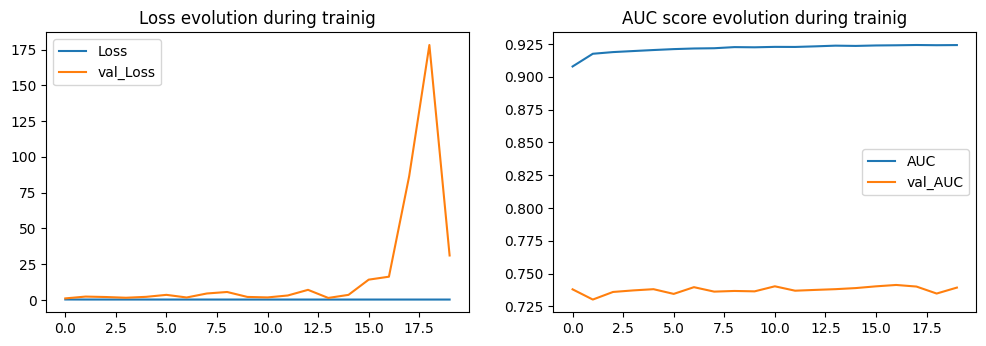

In [46]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

plot_learning_evolution(r)

In [48]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

# Imposta la soglia
threshold = 0.5

# Converte i valori float in valori binari
binary_values = (y_test_pred > threshold).astype(float).flatten()

scores_dict['ANNs'] = {
        'AUC': roc_auc_score(y_test, model.predict(X_test)),
        'Accuracy': accuracy_score(y_test, binary_values)
    } 


25203/25203 [==============================] - 33s 1ms/step
Train Result:
Accuracy Score: 86.25%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      0.9209      0.8183    0.8625      0.8696        0.8696
recall         0.7931      0.9318    0.8625      0.8625        0.8625
f1-score       0.8522      0.8714    0.8625      0.8618        0.8618
support   403246.0000 403246.0000    0.8625 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[319824  83422]
 [ 27483 375763]]

7801/7801 [==============================] - 11s 1ms/step
Test Result:
Accuracy Score: 79.27%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.4916      0.8286    0.7927      0.6601        0.7593
recall        0.2544      0.9320    0.7927      0.5932        0.7927
f1-sco

"    \nscores_dict['ANNs'] = {\n        'AUC': roc_auc_score(y_test, model.predict(X_test)),\n        'Accuracy': accuracy_score(y_test, model.predict(X_test))\n    }  "

In [50]:
"""
Metriche da massimizzare:
-Precision: 'precision'
-Recall:  'recall'
-F1-score: 'f1'
-Accuratezza: 'acc'
-Roc-AUC: 'roc_auc',
-False positive rate: 'fpr'
-False negative rate: 'fnr'
-True positive rate: 'tpr'
-True negative rate: 'tnr'
"""

"""Scelgo la metrica da massimizzare--> togliendo il comemnto da uno di questi"""
#fig, ax, model_disc_threshold_pre = plot_discrimination_threshold(model, X_test, y_test, argmax='precision')
#fig, ax, model_disc_threshold_rec = plot_discrimination_threshold(model, X_test, y_test, argmax='recall')
#fig, ax, model_disc_threshold_f1 = plot_discrimination_threshold(model, X_test, y_test, argmax='f1')
#fig, ax, model_disc_threshold_acc = plot_discrimination_threshold(model, X_test, y_test, argmax='acc')
#fig, ax, model_disc_threshold_auc = plot_discrimination_threshold(model, X_test, y_test, argmax='roc_auc')

""" 
Threshold per massimizzare la precision: 
Threshold per massimizzare la recall: 
Threshold per massimizzare la f1: 
Threshold per massimizzare l'accuratezza: 
Threshold per massimizzare la roc-auc:  
"""

AttributeError: 'Functional' object has no attribute 'predict_proba'

In [ ]:
"""Stampo i risultati"""

# model: ANN
#print("Threshold per massimizzare la precision:", model_disc_threshold_pre)
#print("Threshold per massimizzare la recall:", model_disc_threshold_rec)
#print("Threshold per massimizzare la f1:", model_disc_threshold_f1)
#print("Threshold per massimizzare l'accuratezza:", model_disc_threshold_acc)
#print("Threshold per massimizzare la roc-auc:", model_disc_threshold_auc)

-->Testo la nuova th da sistemare per le ANN

In [63]:
""" new_threshold = model_disc_threshold_acc

# Ottenere le probabilità predette
probs = model.predict_proba(X_test)[:, 1]

# Applicare la soglia per ottenere le predizioni finali
y_test_pred = np.where(probs > new_threshold, 1, 0)

y_train_pred = (model.predict_proba(X_train)[:, 1] >= new_threshold).astype(int) # qua uso il >= VEDO SE CAMBIA QUALCOSA
#y_test_pred = (model.predict_proba(X_test)[:, 1] >= new_threshold).astype(int)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)  """

AttributeError: 'Functional' object has no attribute 'predict_proba'

# ✔️ XGBoost Classifier

In [ ]:
#param_grid = dict(
#    n_estimators=stats.randint(10, 500),
#    max_depth=stats.randint(1, 10),
#    learning_rate=stats.uniform(0, 1)
#)
#xgb_clf = XGBClassifier()
#xgb_cv = RandomizedSearchCV(
#   xgb_clf, param_grid, cv=3, n_iter=60, 
#    scoring='roc_auc', n_jobs=-1, verbose=0
#)
#xgb_cv.fit(X_train, y_train)
#best_params = xgb_cv.best_params_
#print(f"Best Parameters: {best_params}")

#Best Parameters: {'learning_rate': 0.05963949969948923, 'max_depth': 4, 'n_estimators': 379}

""" params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}
xgb_clf = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_cv = RandomizedSearchCV(
   xgb_clf, params, cv=3, n_iter=60, 
    scoring='roc_auc', n_jobs=-1, verbose=0
)
xgb_cv.fit(X_train, y_train)
best_params = xgb_cv.best_params_
print(f"Best Parameters: {best_params}") """

' params = {\n \'learning_rate\' : [0.05,0.10,0.15,0.20,0.25,0.30],\n \'max_depth\' : [ 3, 4, 5, 6, 8, 10, 12, 15],\n \'min_child_weight\' : [ 1, 3, 5, 7 ],\n \'gamma\': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],\n \'colsample_bytree\' : [ 0.3, 0.4, 0.5 , 0.7 ]\n}\nxgb_clf = XGBClassifier(use_label_encoder=False, random_state=0)\nxgb_cv = RandomizedSearchCV(\n   xgb_clf, params, cv=3, n_iter=60, \n    scoring=\'roc_auc\', n_jobs=-1, verbose=0\n)\nxgb_cv.fit(X_train, y_train)\nbest_params = xgb_cv.best_params_\nprint(f"Best Parameters: {best_params}") '

In [51]:
xgb_clf = XGBClassifier(random_state=0)

xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['XGBoost'] = {
        'AUC': roc_auc_score(y_test, xgb_clf.predict(X_test)),
        'Accuracy': accuracy_score(y_test, xgb_clf.predict(X_test))
    }

Train Result:
Accuracy Score: 89.25%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      0.9803      0.8318    0.8925      0.9061        0.9061
recall         0.8010      0.9839    0.8925      0.8925        0.8925
f1-score       0.8816      0.9015    0.8925      0.8916        0.8916
support   403246.0000 403246.0000    0.8925 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[323000  80246]
 [  6477 396769]]

Test Result:
Accuracy Score: 82.55%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.7615      0.8295    0.8255      0.7955        0.8155
recall        0.2192      0.9822    0.8255      0.6007        0.8255
f1-score      0.3404      0.8994    0.8255      0.6199        0.7845
support   51292.0000 198332.0000    0.8255 249624.0000 

c:\Users\TirocinioMatteo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TirocinioMatteo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


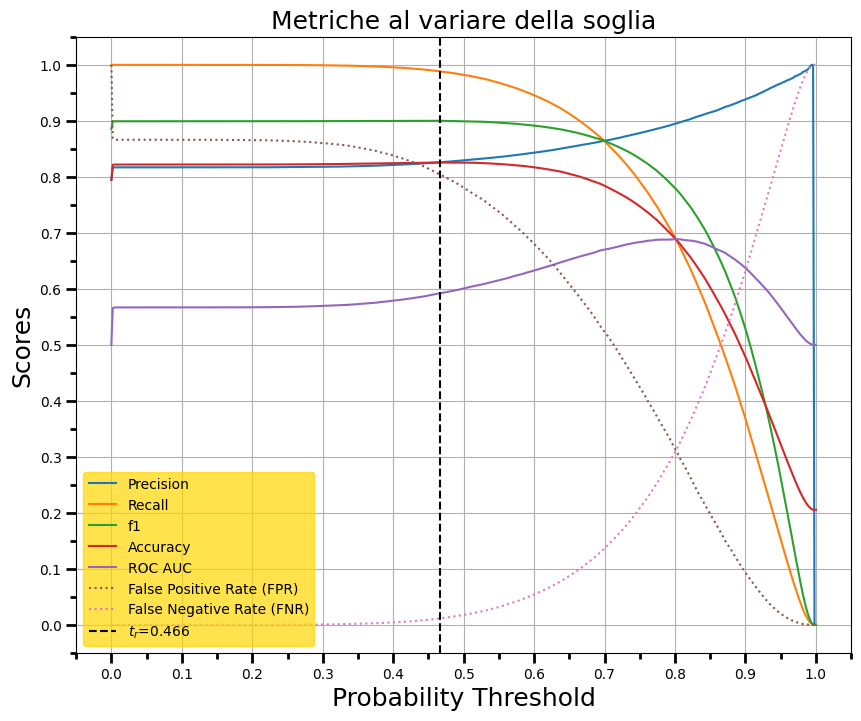

" \nThreshold per massimizzare la precision: 0.99\nThreshold per massimizzare la recall: 0.0\nThreshold per massimizzare la f1: 0.43\nThreshold per massimizzare l'accuratezza: 0.46\nThreshold per massimizzare la roc-auc: 0.8 \n"

In [52]:
"""
Metriche da massimizzare:
-Precision: 'precision'
-Recall:  'recall'
-F1-score: 'f1'
-Accuratezza: 'acc'
-Roc-AUC: 'roc_auc',
-False positive rate: 'fpr'
-False negative rate: 'fnr'
-True positive rate: 'tpr'
-True negative rate: 'tnr'
"""

#fig, ax, xgb_disc_threshold_pre = plot_discrimination_threshold(xgb_clf, X_test, y_test, argmax='precision')
#fig, ax, xgb_disc_threshold_rec = plot_discrimination_threshold(xgb_clf, X_test, y_test, argmax='recall')
#fig, ax, xgb_disc_threshold_f1 = plot_discrimination_threshold(xgb_clf, X_test, y_test, argmax='f1')
fig, ax, xgb_disc_threshold_acc = plot_discrimination_threshold(xgb_clf, X_test, y_test, argmax='acc')
#fig, ax, xgb_disc_threshold_auc = plot_discrimination_threshold(xgb_clf, X_test, y_test, argmax='roc_auc')

""" 
Threshold per massimizzare la precision: 
Threshold per massimizzare la recall: 
Threshold per massimizzare la f1: 
Threshold per massimizzare l'accuratezza: 0.466 ok aggiornata
Threshold per massimizzare la roc-auc: 
"""




In [53]:
#XGBOOST

# ora ho messo round a 4 cifre decimali

#print("Threshold per massimizzare la precision:", xgb_disc_threshold_pre)
#print("Threshold per massimizzare la recall:", xgb_disc_threshold_rec)
#print("Threshold per massimizzare la f1:", xgb_disc_threshold_f1)
print("Threshold per massimizzare l'accuratezza:", xgb_disc_threshold_acc)
#print("Threshold per massimizzare la roc-auc:", xgb_disc_threshold_auc)


Threshold per massimizzare l'accuratezza: 0.466


In [ ]:
"""------> Alternativa per la scelta della soglia che amssimizza l'accuratezza<--------"""

""" from sklearn.metrics import accuracy_score

pred=[] # lista vuota per salvare le probabilità di ciascun modello

# itero su ciascun modello 
for model in [xgb_clf]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1])) # Calcolo le probabilità dei modleli e le aggiungo alla lista pred[]

final_prediction=pd.concat(pred,axis=1).mean(axis=1)  # Calcolo la media delle probabilità dei modelli e le salvo in final_prediction

# Calcolo la curva ROC usando y_test e final_prediction
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)

accuracy_ls = []

for thres in thresholds: # itero tra i valori di thresholds
    y_pred = np.where(final_prediction>thres,1,0) # se il valore di final_prediction è maggiore di thres, allora 1, altrimenti 0
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True)) 
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)

accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head() """

,thresholds,accuracy
71053,0.4684,0.8257
71063,0.4683,0.8257
71051,0.4685,0.8257
71064,0.4683,0.8257
71045,0.4686,0.8257


-->Testo le nuove th

In [62]:
new_threshold = xgb_disc_threshold_acc

# Ottenere le probabilità predette
probs = xgb_clf.predict_proba(X_test)[:, 1]

# Applicare la soglia per ottenere le predizioni finali
y_test_pred = np.where(probs > new_threshold, 1, 0)

y_train_pred = (xgb_clf.predict_proba(X_train)[:, 1] >= new_threshold).astype(int)
#y_test_pred = (xgb_clf.predict_proba(X_test)[:, 1] >= new_threshold).astype(int)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False) 

Train Result:
Accuracy Score: 89.19%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      0.9875      0.8276    0.8919      0.9076        0.9076
recall         0.7938      0.9900    0.8919      0.8919        0.8919
f1-score       0.8801      0.9016    0.8919      0.8908        0.8908
support   403246.0000 403246.0000    0.8919 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[320109  83137]
 [  4045 399201]]

Test Result:
Accuracy Score: 82.57%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.8162      0.8262    0.8257      0.8212        0.8241
recall        0.1957      0.9886    0.8257      0.5922        0.8257
f1-score      0.3157      0.9001    0.8257      0.6079        0.7800
support   51292.0000 198332.0000    0.8257 249624.0000 

In [ ]:
xgb_errors = getRecordsWithIncorrectPrediction(y_test_pred, y_test)
xgb_errors.to_csv('xgb_errors.csv')
xgb_errors_index = getRecordsIndexWithIncorrectPrediction(y_test_pred, y_test)


         loan_amnt  term  int_rate  emp_length  annual_inc  zip_code  \
1983117 20000.0000    60   25.2900           6  83512.0000       300   
1006059  8000.0000    36    6.9700          11  39000.0000       481   
1348891  8700.0000    36   13.5300           7  79000.0000        21   
390397  10000.0000    36   12.9900           2  40000.0000       461   
331792  28000.0000    60   14.6500          11 115000.0000       440   
...            ...   ...       ...         ...         ...       ...   
1313616 11300.0000    36    9.6700          11  58176.0000       117   
55897    8000.0000    36   10.9900          11 160000.0000       953   
1182246 10000.0000    60   22.1500           2  70000.0000       331   
163853  10000.0000    36    5.3200          11  58000.0000       953   
741058  12000.0000    36   18.9900           1  37000.0000       605   

         addr_state     dti  delinq_2yrs  open_acc  pub_rec  \
1983117          10 23.5600       0.0000   14.0000   4.0000   
1006059  

features importance

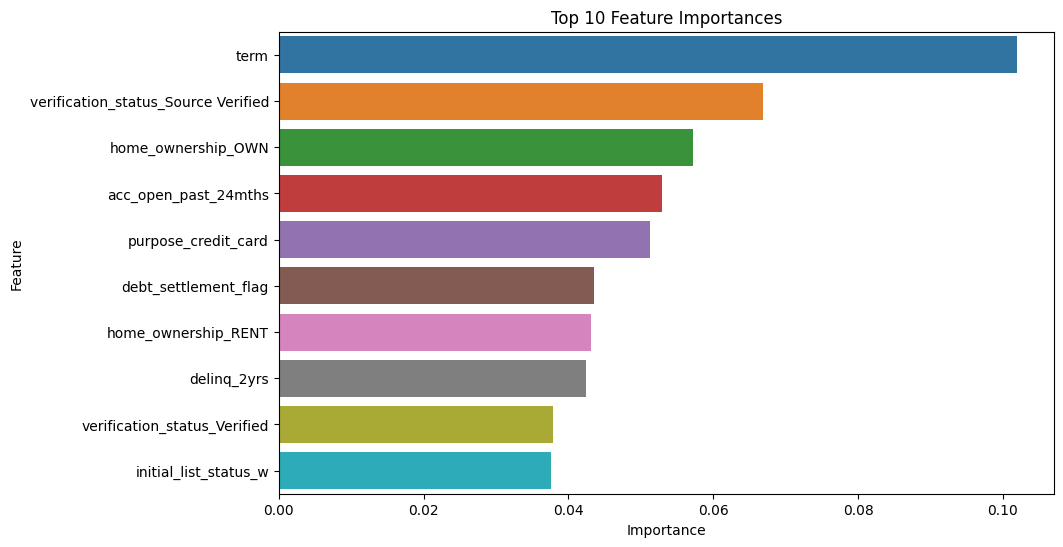

In [ ]:
features_importance = xgb_clf.feature_importances_
# Creazione di un DataFrame per visualizzare l'importanza delle feature
features_importance_df = pd.DataFrame({'Feature': data.drop('loan_status', axis=1).columns, 'Importance': features_importance})
# Ordina le feature per importanza
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)
# Visualizzazione delle prime 10 feature più importanti
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ✔️ Random Forest Classifier

In [ ]:
#param_grid = dict(
#    n_estimators=stats.randint(100, 1500),
#    max_depth=stats.randint(10, 100),
#    min_samples_split=stats.randint(1, 10),
#    min_samples_leaf=stats.randint(1, 10),
#)
#rf_clf = RandomForestClassifier()
#rf_cv = RandomizedSearchCV(
#    rf_clf, param_grid, cv=3, n_iter=60, 
#    scoring='roc_auc', n_jobs=-1, verbose=1
#)
#rf_cv.fit(X_train, y_train)
#best_params = rf_cv.best_params_
#print(f"Best Parameters: {best_params}")

#Best Parameters: {'max_depth': 58, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 1421}

""" parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_cv = RandomizedSearchCV(
    rf_clf, parameters, cv=3, n_iter=60, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}") """

' parameters = {\'criterion\': [\'gini\', \'entropy\', \'log_loss\'],\n              \'max_depth\': [2*n for n in range(1,10)],\n              \'max_features\': [\'auto\', \'sqrt\', \'log2\'],\n              \'min_samples_leaf\': [1, 2, 4],\n              \'min_samples_split\': [2, 5, 10]}\n\nrf_clf = RandomForestClassifier(n_estimators=100, random_state=0)\nrf_cv = RandomizedSearchCV(\n    rf_clf, parameters, cv=3, n_iter=60, \n    scoring=\'roc_auc\', n_jobs=-1, verbose=1\n)\nrf_cv.fit(X_train, y_train)\nbest_params = rf_cv.best_params_\nprint(f"Best Parameters: {best_params}") '

In [54]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Random Forest'] = {
        'AUC': roc_auc_score(y_test, rf_clf.predict(X_test)),
        'Accuracy': accuracy_score(y_test, rf_clf.predict(X_test))
    }

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      1.0000      1.0000    1.0000      1.0000        1.0000
recall         1.0000      1.0000    1.0000      1.0000        1.0000
f1-score       1.0000      1.0000    1.0000      1.0000        1.0000
support   403246.0000 403246.0000    1.0000 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[403242      4]
 [     0 403246]]

Test Result:
Accuracy Score: 81.77%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.6448      0.8328    0.8177      0.7388        0.7942
recall        0.2514      0.9642    0.8177      0.6078        0.8177
f1-score      0.3617      0.8937    0.8177      0.6277        0.7844
support   51292.0000 198332.0000    0.8177 249624.0000

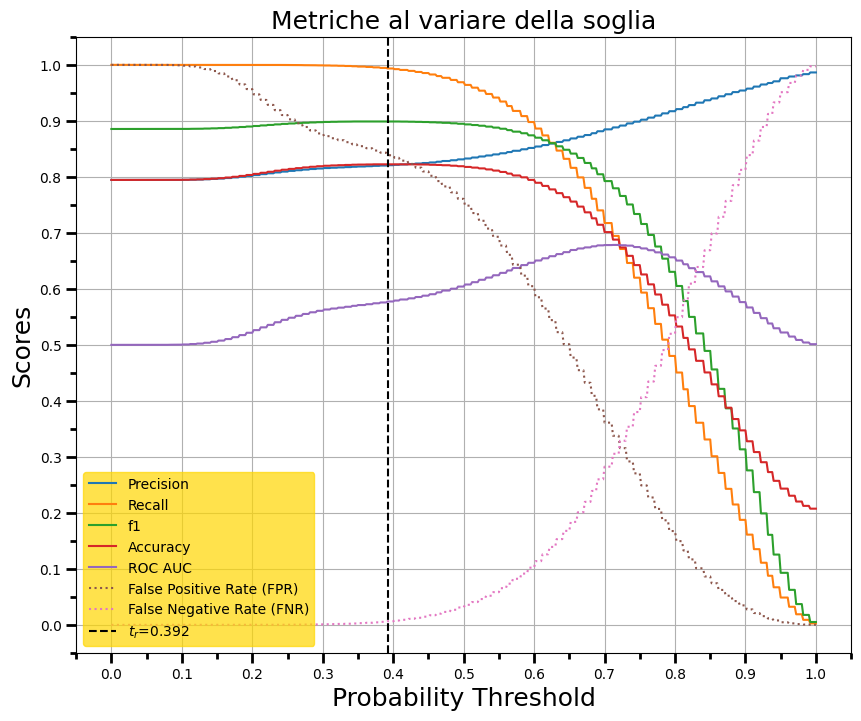

" \nThreshold per massimizzare la precision: \nThreshold per massimizzare la recall: \nThreshold per massimizzare la f1: \nThreshold per massimizzare l'accuratezza: \nThreshold per massimizzare la roc-auc:  \n"

In [55]:
"""
Metriche da massimizzare:
-Precision: 'precision'
-Recall:  'recall'
-F1-score: 'f1'
-Accuratezza: 'acc'
-Roc-AUC: 'roc_auc',
-False positive rate: 'fpr'
-False negative rate: 'fnr'
-True positive rate: 'tpr'
-True negative rate: 'tnr'
"""

#fig, ax, rf_disc_threshold_pre = plot_discrimination_threshold(rf_clf, X_test, y_test, argmax='precision')
#fig, ax, rf_disc_threshold_rec = plot_discrimination_threshold(rf_clf, X_test, y_test, argmax='recall')
#fig, ax, rf_disc_threshold_f1 = plot_discrimination_threshold(rf_clf, X_test, y_test, argmax='f1')
fig, ax, rf_disc_threshold_acc = plot_discrimination_threshold(rf_clf, X_test, y_test, argmax='acc')
#fig, ax, rf_disc_threshold_auc = plot_discrimination_threshold(rf_clf, X_test, y_test, argmax='roc_auc')

""" 
Threshold per massimizzare la precision: 
Threshold per massimizzare la recall: 
Threshold per massimizzare la f1: 
Threshold per massimizzare l'accuratezza: 0.392
Threshold per massimizzare la roc-auc:  
"""

In [56]:
#RANDOM FOREST

#print("Threshold per massimizzare la precision:", rf_disc_threshold_pre)
#print("Threshold per massimizzare la recall:", rf_disc_threshold_rec)
#print("Threshold per massimizzare la f1:", rf_disc_threshold_f1)
print("Threshold per massimizzare l'accuratezza:", rf_disc_threshold_acc)
#print("Threshold per massimizzare la roc-auc:", rf_disc_threshold_auc)

Threshold per massimizzare l'accuratezza: 0.392


-->Testo nuova th

In [61]:
new_threshold = rf_disc_threshold_acc

# Ottenere le probabilità predette
probs = rf_clf.predict_proba(X_test)[:, 1]

# Applicare la soglia per ottenere le predizioni finali
y_test_pred = np.where(probs > new_threshold, 1, 0)

y_train_pred = (rf_clf.predict_proba(X_train)[:, 1] >= new_threshold).astype(int)
#y_test_pred = (rf_clf.predict_proba(X_test)[:, 1] >= new_threshold).astype(int)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 99.92%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      1.0000      0.9985    0.9992      0.9992        0.9992
recall         0.9985      1.0000    0.9992      0.9992        0.9992
f1-score       0.9992      0.9992    0.9992      0.9992        0.9992
support   403246.0000 403246.0000    0.9992 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[402624    622]
 [     0 403246]]

Test Result:
Accuracy Score: 82.25%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.8657      0.8208    0.8225      0.8433        0.8300
recall        0.1614      0.9935    0.8225      0.5775        0.8225
f1-score      0.2721      0.8990    0.8225      0.5855        0.7701
support   51292.0000 198332.0000    0.8225 249624.0000 

In [ ]:
rf_errors = getRecordsWithIncorrectPrediction(y_test_pred, y_test)
rf_errors.to_csv('rf_errors.csv')
rf_errors_index = getRecordsIndexWithIncorrectPrediction(y_test_pred, y_test)

         loan_amnt  term  int_rate  emp_length  annual_inc  zip_code  \
1983117   20000.00    60     25.29           6    83512.00       300   
1529554   35000.00    36     14.03           1    96000.00       928   
1289424   19825.00    60     23.43          11    70000.00       785   
1271547   20800.00    60     20.20           7   142440.00       950   
246535    25000.00    36      5.32           6   150000.00       152   
...            ...   ...       ...         ...         ...       ...   
2218997   25000.00    60     18.99           6    64000.00        33   
1182246   10000.00    60     22.15           2    70000.00       331   
1712657   15000.00    36     19.99           2    30000.00       846   
2036962    2000.00    36     10.49           5    85000.00        73   
402816    12000.00    60     14.31           4    80000.00       103   

         addr_state   dti  delinq_2yrs  open_acc  pub_rec  \
1983117          10 23.56         0.00     14.00     4.00   
1529554      

# ✔️ Logistic Regression

In [57]:
#parameters = {'C': np.logspace(-2, 0, 20),
#              'penalty': ['none', 'l2', 'l1', 'elasticnet'],
#              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']} #{'tol': [ 1e-4, 1e-3,100,1000 ]
#lr = LogisticRegression()
#lr_cv = GridSearchCV(lr, parameters, cv=3, verbose=0, n_jobs=-1) #cv=10 impiega troppo tempo (con cv=3 impiega 35 minuti)
#lr_cv.fit(X_train, y_train)
#best_params = lr_cv.best_params_
#print(f"Best Parameters: {best_params}")

#Best Parameters: {'C': 0.7847599703514611, 'penalty': 'l2', 'solver': 'newton-cg'}

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Logistic Regression'] = {
        'AUC': roc_auc_score(y_test, lr.predict(X_test)),
        'Accuracy': accuracy_score(y_test, lr.predict(X_test))
    }

c:\Users\TirocinioMatteo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Result:
Accuracy Score: 86.78%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      0.9532      0.8095    0.8678      0.8813        0.8813
recall         0.7736      0.9620    0.8678      0.8678        0.8678
f1-score       0.8540      0.8792    0.8678      0.8666        0.8666
support   403246.0000 403246.0000    0.8678 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[311939  91307]
 [ 15321 387925]]

Test Result:
Accuracy Score: 81.93%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.6466      0.8352    0.8193      0.7409        0.7964
recall        0.2655      0.9625    0.8193      0.6140        0.8193
f1-score      0.3764      0.8943    0.8193      0.6354        0.7879
support   51292.0000 198332.0000    0.8193 249624.0000 

c:\Users\TirocinioMatteo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


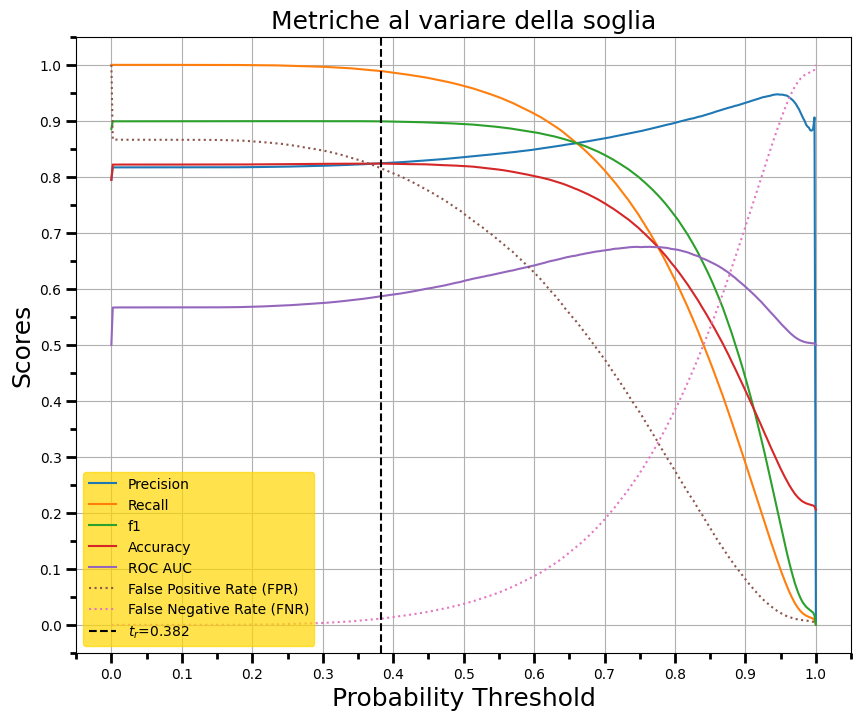

In [58]:
"""
Metriche da massimizzare:
-Precision: 'precision'
-Recall:  'recall'
-F1-score: 'f1'
-Accuratezza: 'acc'
-Roc-AUC: 'roc_auc',
-False positive rate: 'fpr'
-False negative rate: 'fnr'
-True positive rate: 'tpr'
-True negative rate: 'tnr'
"""

#fig, ax, lr_disc_threshold_pre = plot_discrimination_threshold(lr, X_test, y_test, argmax='precision')
#fig, ax, lr_disc_threshold_rec = plot_discrimination_threshold(lr, X_test, y_test, argmax='recall')
#fig, ax, lr_disc_threshold_f1 = plot_discrimination_threshold(lr, X_test, y_test, argmax='f1')
fig, ax, lr_disc_threshold_acc = plot_discrimination_threshold(lr, X_test, y_test, argmax='acc')
#fig, ax, lr_disc_threshold_auc = plot_discrimination_threshold(lr, X_test, y_test, argmax='roc_auc')

""" 
Threshold per massimizzare la precision: 
Threshold per massimizzare la recall: 
Threshold per massimizzare la f1: 
Threshold per massimizzare l'accuratezza: 0.382
Threshold per massimizzare la roc-auc:  
"""

In [59]:
#Log regressiion

#print("Threshold per massimizzare la precision:", lr_disc_threshold_pre)
#print("Threshold per massimizzare la recall:", lr_disc_threshold_rec)
#print("Threshold per massimizzare la f1:", lr_disc_threshold_f1)
print("Threshold per massimizzare l'accuratezza:", lr_disc_threshold_acc)
#print("Threshold per massimizzare la roc-auc:", lr_disc_threshold_auc)

Threshold per massimizzare l'accuratezza: 0.382


-->Testo nuova th

In [60]:
new_threshold = lr_disc_threshold_acc

# Ottenere le probabilità predette
probs = lr.predict_proba(X_test)[:, 1]

# Applicare la soglia per ottenere le predizioni finali
y_test_pred = np.where(probs > new_threshold, 1, 0)

y_train_pred = (lr.predict_proba(X_train)[:, 1] >= new_threshold).astype(int)
#y_test_pred = (lr.predict_proba(X_test)[:, 1] >= new_threshold).astype(int)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False) 

Train Result:
Accuracy Score: 86.51%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision      0.9846      0.7929    0.8651      0.8888        0.8888
recall         0.7419      0.9884    0.8651      0.8651        0.8651
f1-score       0.8462      0.8799    0.8651      0.8631        0.8631
support   403246.0000 403246.0000    0.8651 806492.0000   806492.0000
_______________________________________________
Confusion Matrix: 
 [[299157 104089]
 [  4676 398570]]

Test Result:
Accuracy Score: 82.38%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0         1.0  accuracy   macro avg  weighted avg
precision     0.8140      0.8242    0.8238      0.8191        0.8221
recall        0.1844      0.9891    0.8238      0.5868        0.8238
f1-score      0.3007      0.8992    0.8238      0.5999        0.7762
support   51292.0000 198332.0000    0.8238 249624.0000 

In [ ]:
lr_errors = getRecordsWithIncorrectPrediction(y_test_pred, y_test)
lr_errors.to_csv('lr_errors.csv')
lr_errors_index = getRecordsIndexWithIncorrectPrediction(y_test_pred, y_test)

         loan_amnt  term  int_rate  emp_length  annual_inc  zip_code  \
1983117   20000.00    60     25.29           6    83512.00       300   
1529554   35000.00    36     14.03           1    96000.00       928   
246535    25000.00    36      5.32           6   150000.00       152   
722176    11200.00    60     22.45           5   138000.00       750   
1170862   25000.00    36     12.99           1    70000.00       750   
...            ...   ...       ...         ...         ...       ...   
1182246   10000.00    60     22.15           2    70000.00       331   
1712657   15000.00    36     19.99           2    30000.00       846   
2036962    2000.00    36     10.49           5    85000.00        73   
741058    12000.00    36     18.99           1    37000.00       605   
402816    12000.00    60     14.31           4    80000.00       103   

         addr_state   dti  delinq_2yrs  open_acc  pub_rec  \
1983117          10 23.56         0.00     14.00     4.00   
1529554      

# ✔️ k-nearest Neighbors

In [ ]:
#parameters = {'n_neighbors': list(range(1, 20)),
#              'weights': ['uniform', 'distance'],
#              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#              'p': [1,2]}
#knn = KNeighborsClassifier()
#grid_search = GridSearchCV(knn, parameters, cv=3, verbose=0, n_jobs=-1) #con cv=3 impiega 6 ore e 30 minuti
#knn_cv = grid_search.fit(X_train, y_train)
#knn_cv.fit(X_train, y_train)
#best_params = knn_cv.best_params_
#print(f"Best Parameters: {best_params}")

#Best Parameters: {'algorithm': 'auto', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}

""" knn = KNeighborsClassifier(n_neighbors=19)   
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['k-nearest Neighbors'] = {
        'AUC': roc_auc_score(y_test, knn.predict(X_test)),
        'Accuracy': accuracy_score(y_test, knn.predict(X_test))
    }     """

" knn = KNeighborsClassifier(n_neighbors=19)   \nknn.fit(X_train, y_train)\n\ny_train_pred = knn.predict(X_train)\ny_test_pred = knn.predict(X_test)\n\nprint_score(y_train, y_train_pred, train=True)\nprint_score(y_test, y_test_pred, train=False)\n\nscores_dict['k-nearest Neighbors'] = {\n        'AUC': roc_auc_score(y_test, knn.predict(X_test)),\n        'Accuracy': accuracy_score(y_test, knn.predict(X_test))\n    }     "

# ✔️ Support Vector Machine

In [ ]:
#parameters = {'C': np.logspace(-3, 3, 10),
#              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#              'degree': list(range(2,5)),
#              'gamma': np.logspace(-3, 1, 10)}
#svm = SVC()
#grid_search = RandomizedSearchCV(
#    svm, parameters, cv=3, n_iter=60, 
#    scoring='roc_auc', n_jobs=-1, verbose=0
#)
#svm_cv = grid_search.fit(X_train, y_train)
#svm_cv.fit(X_train, y_train)
#best_params = svm_cv.best_params_
#print(f"Best Parameters: {best_params}")

#Best Parameters: 

""" svm = SVC(random_state=0)   
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Support Vector Machine'] = {
        'AUC': roc_auc_score(y_test, svm.predict(X_test)),
        'Accuracy': accuracy_score(y_test, svm.predict(X_test))
    }   """  

" svm = SVC(random_state=0)   \nsvm.fit(X_train, y_train)\n\ny_train_pred = svm.predict(X_train)\ny_test_pred = svm.predict(X_test)\n\nprint_score(y_train, y_train_pred, train=True)\nprint_score(y_test, y_test_pred, train=False)\n\nscores_dict['Support Vector Machine'] = {\n        'AUC': roc_auc_score(y_test, svm.predict(X_test)),\n        'Accuracy': accuracy_score(y_test, svm.predict(X_test))\n    }   "

# ✔️ Decision Tree

In [ ]:
#parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
#              'splitter': ['best', 'random'],
#              'max_depth': [2*n for n in range(1,10)],
#              'max_features': ['auto', 'sqrt', 'log2'],
#              'min_samples_leaf': [1, 2, 4],
#              'min_samples_split': [2, 5, 10]}
#tree = DecisionTreeClassifier()
#grid_search = RandomizedSearchCV(
#    tree, parameters, cv=3, n_iter=60, 
#    scoring='roc_auc', n_jobs=-1, verbose=0
#)
#tree_cv = grid_search.fit(X_train, y_train)
#tree_cv.fit(X_train, y_train)
#best_params = tree_cv.best_params_
#print(f"Best Parameters: {best_params}")

#Best Parameters: 

""" tree = DecisionTreeClassifier(random_state=0)   
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Decision Tree'] = {
        'AUC': roc_auc_score(y_test, tree.predict(X_test)),
        'Accuracy': accuracy_score(y_test, tree.predict(X_test))
    }   """  

" tree = DecisionTreeClassifier(random_state=0)   \ntree.fit(X_train, y_train)\n\ny_train_pred = tree.predict(X_train)\ny_test_pred = tree.predict(X_test)\n\nprint_score(y_train, y_train_pred, train=True)\nprint_score(y_test, y_test_pred, train=False)\n\nscores_dict['Decision Tree'] = {\n        'AUC': roc_auc_score(y_test, tree.predict(X_test)),\n        'Accuracy': accuracy_score(y_test, tree.predict(X_test))\n    }   "

# 📊 Comparing Models Performance

In [ ]:
print("Confronto XG Boost con Random Forest")
compareTwoModels(xgb_errors_index, rf_errors_index)
print("Confronto XG Boost con Logistic Regression")
compareTwoModels(xgb_errors_index, lr_errors_index)
print("Confronto Random Forest con Logistic Regression")
compareTwoModels(rf_errors_index, lr_errors_index)

Confronto XG Boost con Random Forest
Predizioni errate in comune: 38960
Predizioni errate diversi: 11151 

Confronto XG Boost con Logistic Regression
Predizioni errate in comune: 39101
Predizioni errate diversi: 10488 

Confronto Random Forest con Logistic Regression
Predizioni errate in comune: 38917
Predizioni errate diversi: 12785 



In [ ]:
for model in scores_dict:
    print(f"{model.upper():{30}} roc_auc_score: {scores_dict[model]['AUC']:.3f}            accuracy: {scores_dict[model]['Accuracy']*100:.2f}%")


XGBOOST                        roc_auc_score: 0.601            accuracy: 82.55%
RANDOM FOREST                  roc_auc_score: 0.608            accuracy: 81.77%
LOGISTIC REGRESSION            roc_auc_score: 0.614            accuracy: 81.93%


In [ ]:
# Ottieni i nomi delle feature 
feature_names = data.columns
print(data.shape)
print(feature_names)

# Converti l'indice delle colonne in una lista
feature_names_list = feature_names.tolist()

# Crea un DataFrame con una singola colonna usando i nomi delle feature
feature_names_df = pd.DataFrame(feature_names_list, columns=['Feature Names'])

# Esporta i nomi delle feature in un file CSV
feature_names_df.to_csv('feature_names.csv', index=False)

(756435, 159)
Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc',
       'loan_status', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       ...
       'emp_title_stylist', 'emp_title_svp', 'emp_title_system_analyst',
       'emp_title_table_games_dealer', 'emp_title_trainer', 'emp_title_usps',
       'emp_title_vp_of_operations', 'emp_title_waiter', 'emp_title_waitress',
       'emp_title_walmart'],
      dtype='object', length=159)


In [ ]:
scores_df = pd.DataFrame(scores_dict)
scores_df.hvplot.barh(
    width=500, height=400, 
    title="Scores of ML Models", xlabel="Scores", 
    alpha=0.4, legend='top'
)

:Bars   [index,Variable]   (value)